# Employment by Regions in Georgia

Purpose of this notebook is to create a **map of Georgia** with colors reflecting a statistic of employment by regions. For this purpose, the `coolwarm` colormap is used, so that regions with statistically less employment will appear in cooler colors on the map and the regions with statistically higher employment will appear in warmer colors. The exact meaning of each color is explained in the legend placed next to the map itself. See the resulting map in the end of this notebook. 

Data sources:
- Statistical data of the Labour Force Indicators by Regions of Georgia is retrieved on Jun 1, 2022 from the website of the National Statistics Office of Georgia: [geostat.ge](https://www.geostat.ge/en/)
- Map data of the borders of the administrative areas of Georgia (GADM data v4.0 for Georgia in `Shapefile` format) is retrieved on Jun 1, 2022 from the GADM website: [gadm.org](https://gadm.org)


In [1]:
from datetime import datetime, timedelta
nb_st = datetime.utcnow()
print(f"\nNotebook START time: {nb_st} UTC\n")


Notebook START time: 2022-06-15 21:00:14.379180 UTC



In [2]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Python Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Python Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide();
    $('div.input:contains("%%HTML")').removeClass( "input")
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="Show Python Code">
</form>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas

In [4]:
VERBOSE=False

In [5]:
DATA_FILE_PATH = "data/05-Labour-Force-Indicators-by-regions.xlsx"


def read_employment_data_of_year(
        year: int,
        target_feature: str,
        excel_path: str = DATA_FILE_PATH) -> pd.DataFrame:
    df = pd.read_excel(excel_path)
    df = df.loc[df.index >= df.loc[df.iloc[:,0] == year].index.item()]
    col_names = df.head(2).tail(1).values
    df = df.loc[df.iloc[:,0] == target_feature].head(1)
    df.columns = col_names[0]
    df = df.T.reset_index()
    df.columns = ['Region', target_feature]
    df = df.dropna()
    df = df.sort_values(by=target_feature, ascending=True)
    return df.reset_index(drop=True)

In [6]:
features_available = [
    'Total 15 + population',  # 0
    'Labour force',  # 1
    'Employed',  # 2
    'Hired',  # 3
    'Self-employed',  # 4
    'Not-identified worker',  # 5
    'Unemployed',  # 6
    'Population outside labour force',  # 7
]
year, target_feature = 2021, features_available[3]
df = read_employment_data_of_year(year, target_feature)
print(f"\nData for {year} year:\n")
display(df)


Data for 2021 year:



,Region,Hired
0,Racha-Lechkhumi and Kvemo-Svaneti,7.102363
1,Guria,17.835517
2,Mtskheta-Mtianeti,21.370056
3,Samtskhe-Javakheti,30.006213
4,Shida Kartli,51.550302
5,Kakheti,56.537744
6,Samegrelo-Zemo Svaneti,58.569218
7,Kvemo Kartli,76.423655
8,Adjara A/R,80.63719
9,Imereti,101.9573


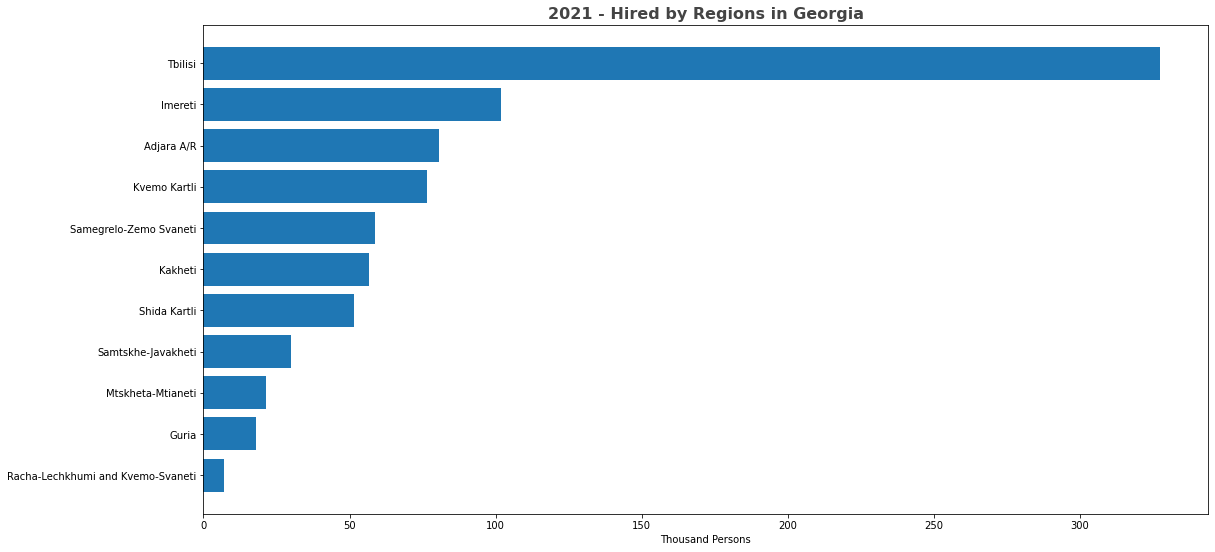

In [7]:
plt.figure(figsize=(18,9))
plt.barh(
    data=df.loc[df['Region'] !='Georgia'],
    y='Region',
    width=target_feature,
)
plt.title(f'{year} - {target_feature} by Regions in Georgia',
          fontdict={
              'fontsize': 16,
              'fontweight': 'bold',
              'color': '#444444',
              'verticalalignment': 'baseline',
              'horizontalalignment': 'center',
          })
plt.xlabel('Thousand Persons')
plt.show()

In [8]:
ADMINISTRATIVE_BORDERS_FILE_PATH = 'data/GADM/gadm40_GEO_shp/gadm40_GEO_1.shp'

Georgia_geodf = geopandas.read_file(ADMINISTRATIVE_BORDERS_FILE_PATH)

In [9]:
if VERBOSE:
    print(Georgia_geodf['NAME_1'].unique())

In [10]:
if VERBOSE:
    print('Check if there is any mismatch in region names '
          'between data and map:')
    df.set_index('Region').index.difference(Georgia_geodf['NAME_1'].unique())

In [11]:
if VERBOSE:
    print('Resolving name mismatch detected earlier '
          'in order to connect employment data to map data...')

df = df.replace(
    {
        'Adjara A/R': 'Ajaria',
        'Racha-Lechkhumi and Kvemo-Svaneti': 'Racha-Lechkhumi-Kvemo Svaneti',
    })

In [12]:
if VERBOSE:
    print('Checking if mismatch is resolved (expecting no region names):')
    df.set_index('Region').index.difference(Georgia_geodf['NAME_1'].unique())

In [13]:
merged_geodf = Georgia_geodf.merge(df,
                                   left_on='NAME_1',
                                   right_on='Region',
                                   how='left').fillna(0)

if VERBOSE:
    print("Map data with statistics for the "
          f"{len(Georgia_geodf['NAME_1'].unique())} regions of Georgia "
          "is ready.")

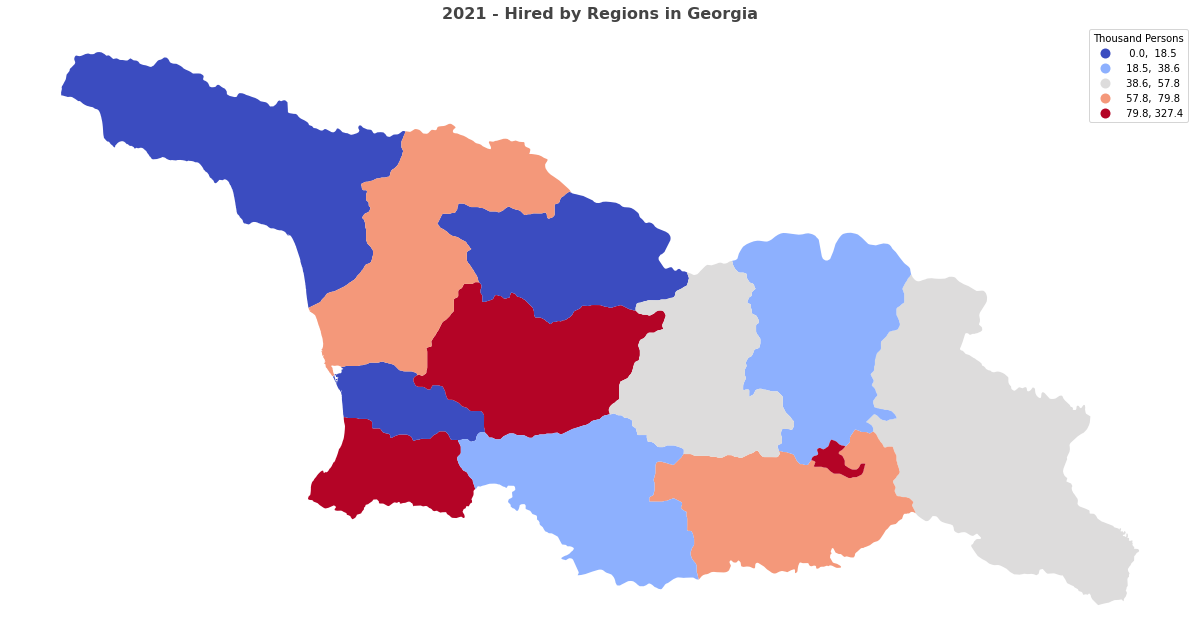

In [14]:
merged_geodf.plot(
    column=target_feature,
    scheme="Quantiles",
    figsize=(18, 9),
    legend=True,
    legend_kwds = {"fmt": "{:.1f}", "title": "Thousand Persons"},
    cmap='coolwarm',
)
plt.gca().set_axis_off()
plt.title(f'{year} - {target_feature} by Regions in Georgia',
          fontdict={
              'fontsize': 16,
              'fontweight': 'bold',
              'color': '#444444',
              'verticalalignment': 'baseline',
              'horizontalalignment': 'center'
          })
plt.tight_layout()
plt.gcf().savefig("map.png")
plt.show()

In [15]:
print(f"\n ** Total Elapsed time: {datetime.utcnow() - nb_st} ** \n")
print(f"Notebook END time: {datetime.utcnow()} UTC\n")


 ** Total Elapsed time: 0:00:01.622031 ** 

Notebook END time: 2022-06-15 21:00:16.001277 UTC




*This notebook is originally published under the Apache License (Version 2.0) at the following GitHub repository: [sentinel-1/employment_map_Georgia](https://github.com/sentinel-1/employment_map_Georgia)*

For the issues, feedback or suggestions regarding the original notebook (if any) feel free to open an issue at the corresponding [Issues page of the repository](https://github.com/sentinel-1/employment_map_Georgia/issues)